In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank, DyadicFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import *

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [2]:
data = np.load("data.npy")
#data = np.concatenate((data, data), axis=0)  # Duplicate the data to create two channels

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array

B1 = data + 100 *np.sin(2 * np.pi * 6.4 * t) + 50 * np.sin(2 * np.pi * 12.8 * t)
B2 = data + 400 *np.sin(2 * np.pi * 6.4 * t) + 10*np.sin(2 * np.pi * 12.8 * t)
B = np.vstack((B1,B2))


#### Create Transform Object and Analysis Filters

In [3]:
fb = DyadicFilterBank(wavelet=Cauchy(1000) , fs=sample_rate, N=num_samples, real=True, s_max = 1, dj = 1/12)
fb = LinearFilterBank(wavelet=Cauchy(1000), N=num_samples, real=True, fs =sample_rate)
transform = Transform(
    data=B[0],
    fs = sample_rate,
    filterbank=fb,
)

#### Transform


In [4]:
# Perform forward wavelet transform
w1 = transform.forward(B[0])  # shape (J, T), complex
w2 = transform.forward(B[1])  # shape (J, T), complex


D = w2 - w1  # shape (J, T), complex

# 1) correlations (eqs 6–7), using conjugate inner products
C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

# 2) gain estimate K̂ per scale (eq 8)
K_hat = C2 / C1                          # shape (J,)
# (optionally force to real if you know K is real:)
K_hat = K_hat

# 3) stray‑field estimate A(s,τ) (eq 9)
A = D / (K_hat[:,None] - 1)              # shape (J, T), complex

# 4) ambient‑field estimate X(s,τ) (eq 10)
X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 

result = transform.inverse(np.copy(X))


In [5]:
print("Raw Error: ", np.sqrt(((B[0,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Raw Error: ", np.sqrt(((B[1,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Cleaned Error: ", np.sqrt(((data[1000:-1000]-result[1000:-1000])**2).mean(axis=0)))

%matplotlib inline
fig, ax = plt.subplots(2,1)

ax[0].legend()
ax[0].plot(B[0])
ax[0].plot(data)
ax[1].plot(result)
ax[1].plot(data)

Raw Error:  78.96479159894798
Raw Error:  282.8180791278187
Cleaned Error:  3.0261917838729238


C:\Users\Alex\AppData\Local\Temp\ipykernel_7096\367130272.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


In [9]:
transform.scalogram(X, vmin=0, interpolation='none')
transform.scalogram(w2,vmin=0, interpolation='none')

#### Compare to Normal WAICUP

In [7]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend= False
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
print(np.sqrt(((data-result)**2).mean(axis=0)))
plt.plot(data, label='Original Data')
plt.plot(result, label='WAICUP V2')
plt.plot(result_baseline, label='WAICUP V1')
plt.legend()

(199.67710912648752+0j)
2.671775533321345


c:\ProgramData\Anaconda3\envs\latest\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\Anaconda3\envs\latest\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


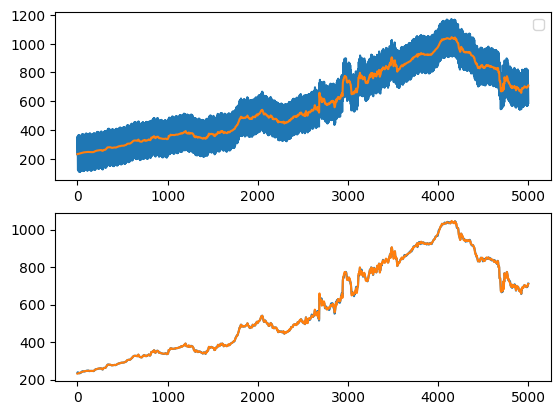

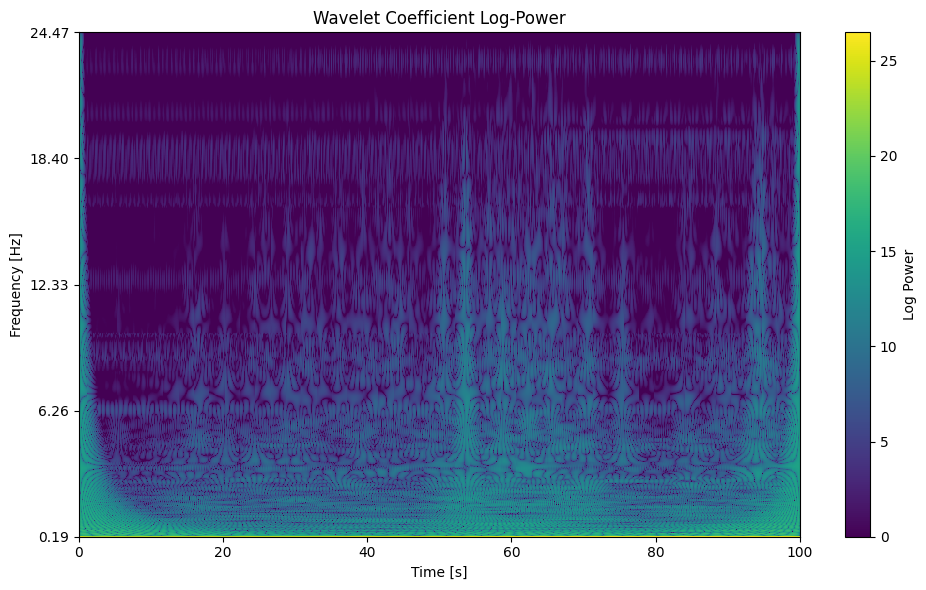

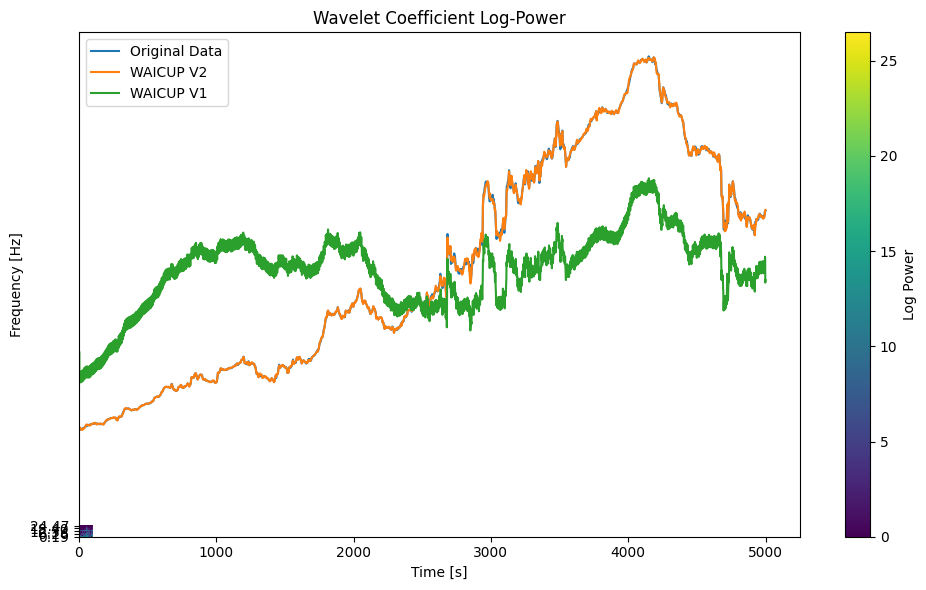

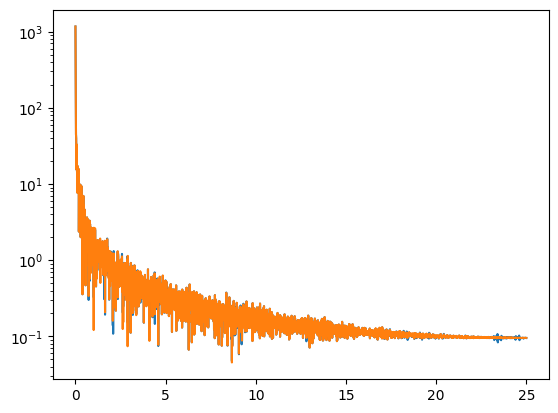

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 5000
# sample spacing
T = 1.0 / 50
x = np.linspace(0.0, N*T, N)
y = data
yf = scipy.fftpack.fft(y)
yf2 = scipy.fftpack.fft(result)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf2[:N//2]))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))


ax.set_yscale('log')
plt.show()


In [9]:
fig, ax = plt.subplots(2,1)
i = 0
N = w1.shape[-1]
freqs = np.fft.fftfreq(N, d=1/sample_rate)
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i][:N//2]))
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i+1][:N//2]))
ax[1].plot(freqs[:N//2], np.abs(np.fft.fft(w1, axis=1))[i][:N//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')